Author : Akash Kharita (ak287@uw.edu)

In [2]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns 

# for converting the text file containing the quarry locations into csv file
import csv

# for computing the geographical distance between two points 
import math


from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from datetime import datetime
import h5py
from sklearn.preprocessing import LabelEncoder
from scipy import stats, signal
from sklearn.preprocessing import StandardScaler
import obspy
from obspy.geodetics.base import gps2dist_azimuth, gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope



import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
import seis_feature
#from seis_feature import compute_physical_features
from datetime import timedelta
import os
import sys
sys.path.append('../src')


from utils import apply_cosine_taper, butterworth_filter, resample_array

import pickle
from zenodo_get import zenodo_get

## Defining some custom functions

In [3]:
# Function to extract information
def extract_datetime_info(date_str):
    date_obj = datetime.strptime(date_str, '%Y_%m_%d %H%M%S')
    hour_of_day = date_obj.hour - 8
    day_of_week = date_obj.weekday()  # Full day name
    month_of_year = date_obj.month  # Full month name
    return hour_of_day, day_of_week, month_of_year



def conv_to_datetime(df):
    new_df = []
    for i in range(len(df)):
        year = int(df[i].split('_')[0])
        month = int(df[i].split('_')[1])
        day = int(df[i].split('_')[2].split(' ')[0])
        hour = int(df[i].split('_')[2].split(' ')[1][0:2])
        minute = int(df[i].split('_')[2].split(' ')[1][2:4])
        second = int(df[i].split('_')[2].split(' ')[1][4:])
        new_df.append(obspy.UTCDateTime(year, month, day, hour, minute, second))
        
    return np.array(new_df)

## Downloading the IRIS ESEC Catalog

In [67]:
pd.set_option('display.max_columns', None)
cat_all = pd.read_csv('../data/IRISExoticEventCatalog.txt', sep='|')
cat = cat_all.copy()
cat

,areaSource,areaSourceHigh,areaSourceLow,areaTotal,associationId,datlocation,depth,endtime,eventid,h,hHigh,hLow,hfall,hfall_high,hfall_low,l,lHigh,lLow,latitude,locuncertKm,longitude,lppotential,mass,massHigh,massLow,maxdistvhfKm,maxdistvhfReached,maxdisthfKm,maxdisthfReached,maxdistipKm,maxdistipReached,maxdistlpKm,maxdistlpReached,maxdistinfraKm,maxdistinfraReached,infraDetected,name,otherdataquality1to5,peakDischarge,peakDischargeLow,peakDischargeHigh,peakFlowheight,peakFlowheightLow,peakFlowheightHigh,starttime,sources,toeLat,toeLon,topLat,topLon,upstreamDrainarea,type,subtype,volume,volumeHigh,volumeLow
0,NaN,NaN,NaN,NaN,22,IRIS,NaN,2007_07_25 010251,22,1860.0,NaN,NaN,NaN,NaN,NaN,5760.0,NaN,NaN,61.10249,0.00,-140.30550,1,1.080000e+11,NaN,NaN,NaN,NaN,1079.0,True,NaN,NaN,1100.0,False,NaN,NaN,NaN,Mount Steele 2,5,NaN,NaN,NaN,NaN,NaN,NaN,2007_07_25 005835,"Allstadt, Kate E., McVey, Brennah G., and Malo...",61.14054,-140.25324,61.10249,-140.30550,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,54000000.0,80500000.0,27500000.0
1,NaN,NaN,NaN,NaN,218,"RESIF, ETH, ORFEUS, LMU, BGR, IRIS, INGV",NaN,2017_08_23 093828,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.29552,NaN,9.60190,0,NaN,NaN,NaN,NaN,NaN,246.0,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN,"Piz Cengalo 4, Switzerland",1,NaN,NaN,NaN,NaN,NaN,NaN,2017_08_23 093617,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,landslide,Rock/ice/debris avalanches and slides,NaN,NaN,NaN
2,111000.0,NaN,NaN,1130000.0,127,IRIS,NaN,2017_07_22 205957,127,931.0,NaN,NaN,NaN,NaN,NaN,3730.0,NaN,NaN,60.07385,0.00,-139.84532,1,NaN,NaN,NaN,NaN,NaN,351.0,False,NaN,NaN,386.0,False,0.0,NaN,False,Lucia Glacier,4,NaN,NaN,NaN,NaN,NaN,NaN,2017_07_22 205630,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",60.06616,-139.90755,60.07385,-139.84532,NaN,rock avalanche,Rock/ice/debris avalanches and slides,3000000.0,4000000.0,2300000.0
3,100000.0,150000.0,65000.0,820000.0,186,"IRIS, NCEDC",NaN,2013_07_25 101727,186,690.0,760.0,640.0,NaN,NaN,NaN,2000.0,2100.0,1600.0,61.98450,0.00,-143.16830,1,4.000000e+10,NaN,NaN,NaN,NaN,500.0,False,NaN,NaN,500.0,False,NaN,NaN,NaN,Wrangell Mountains,4,NaN,NaN,NaN,NaN,NaN,NaN,2013_07_25 101456,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",61.97220,-143.14950,61.98450,-143.16830,NaN,rock and debris avalanche,Rock/ice/debris avalanches and slides,2600000.0,3900000.0,1800000.0
4,23400.0,NaN,NaN,NaN,147,IRIS,NaN,2019_05_13 144245,147,1240.0,NaN,NaN,NaN,NaN,NaN,4320.0,NaN,NaN,50.34480,0.00,-122.45110,1,NaN,NaN,NaN,NaN,NaN,391.0,True,NaN,NaN,301.0,True,NaN,NaN,NaN,Mount Joffre 1,5,NaN,NaN,NaN,NaN,NaN,NaN,2019_05_13 143955,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",50.36720,-122.41540,50.34480,-122.45110,NaN,"rock avalanche, debris flow",Rock/ice/debris avalanches and slides,1900000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,NaN,NaN,NaN,NaN,185,Attachments below,NaN,2015_06_09 160558,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.67199,NaN,10.72268,0,NaN,NaN,NaN,3.0,NaN,3.0,True,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Gadria 3,5,27.0,NaN,NaN,1.7,NaN,NaN,2015_06_09 151558,"Coviello, V., Arattano, M., Comiti, F., Maccon...",NaN,NaN,NaN,NaN,6.3,debris flow,Lahar/debris flow/outburst flood,12600.0,NaN,NaN
241,310000.0,520000.0,200000.0,7900000.0,19,IRIS,NaN,2012_06_11 222652,19,2400.0,2500.0,2300.0,NaN,NaN,NaN,9300.0,9500.0,9100.0,58.79367,0.00,-137.44247,1,2.000000e+10,NaN,NaN,NaN,NaN,890.0,True,NaN,NaN,1000.0,False,NaN,NaN,NaN,Mount Lituya main,4,NaN,NaN,NaN,NaN,NaN,NaN,2012_06_11 222400,"Allstadt, Kate E., McVey, Brennah G., and Malo...",58.81626,-137.30032,58.79367,-137.44247,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,13000000.0,60000000.0,2800000.0
242,130000.0,160000.0,84000.0,3000000.0,188,"IRIS, NCEDC",NaN,2010_07_09 073820,188,1800.0,1900.0,

## Each event in this is identified by a unique Event ID

In [68]:
event_ids = cat['eventid'].values
source_types = cat['type'].values
source_subtypes = cat['subtype'].values

## Extracting Manual Features

In [69]:
hod = [extract_datetime_info(i)[0] for i in cat['starttime'].values]
dow = [extract_datetime_info(i)[1] for i in cat['starttime'].values]
moy = [extract_datetime_info(i)[2] for i in cat['starttime'].values]

## Computing the duration of each event

In [70]:
## computing the durations
sttime = cat['starttime']
ettime = cat['endtime']

starttimes = conv_to_datetime(sttime)
endtimes = conv_to_datetime(ettime)
dur = conv_to_datetime(ettime) - conv_to_datetime(sttime)

## Loading the data 

We have a waveforms corresponding to the event ids stored in directory. These waveforms were downloaded at (P - 70, P+110) [180s]

In [300]:
st_z = []
st_data = []
evids = []
hod_trace = []
dow_trace = []
moy_trace = []
event_types = []
event_subtypes = []
event_duration = []
trids = []


for i in range(len(event_ids)):
    try:
        files = glob("../data/iris_esec_waveforms/IRIS_ESEC/waveforms/"+str(event_ids[i])+'/*HZ*')
        for file in files:
            tr = obspy.read(file)
            tr = tr.detrend(type = 'linear')
            d = tr[0].resample(100).data
            
            ## We are going to test the ml_40 model (so we will use P-10, P+30)
            data = d[8500:12500]
            snr = np.nanmax(abs(data))/np.nanmean(abs(data))

            if snr > 5:
                st_data.append(data)
                evids.append(event_ids[i])           
                trids.append(tr[0].id)
                hod_trace.append(hod[i])
                dow_trace.append(dow[i])
                moy_trace.append(moy[i])
                event_types.append(source_types[i])
                event_subtypes.append(source_subtypes[i])
                event_duration.append(dur[i])
                
    except:
        pass
    

## Processing the downloaded waveforms for the events corresponding to ESEC

In [301]:
st_array = np.stack(st_data)
tapered_ex = apply_cosine_taper(st_array, taper_percent = 10) 
filtered_ex = np.array(butterworth_filter(tapered_ex, 0.5, 15, 100, 4, 'bandpass'))
orig_sr = 100
new_sr = 50
normalized_data = filtered_ex / np.max(abs(filtered_ex), axis=1)[:, np.newaxis]
resampled_data = np.array([resample_array(arr, orig_sr, new_sr) for arr in normalized_data])

## Extracting physical features

In [302]:
code_sttime = time.time()
features_ex_physical = pd.DataFrame([])

for i in tqdm(range(len(resampled_data))):
    try: 
        df = seis_feature.FeatureCalculator(resampled_data[i], fs  = new_sr).compute_features()
        df['serial_no'] = i
        df['event_id'] = evids[i]
        df['trace_id'] = trids[i]
        df['hod'] = hod_trace[i]
        df['dow'] = dow_trace[i]
        df['moy'] = moy_trace[i]
        df['event_type'] = event_types[i]
        df['event_subtype'] = event_subtypes[i]
        df['duration'] = event_duration[i]
        features_ex_physical = pd.concat([features_ex_physical, df])
    except:
        pass
    
print(time.time() - code_sttime)

  0%|          | 0/193 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/notebooks/../feature_extraction_scripts/physical_feature_extraction_scripts/seis_feature.py:159: RuntimeWarning: invalid value encountered in double_scalars
  'Gamma': lambda: ((np.dot(self.freq, self.ft**(2)) / np.sum(self.ft**(2)))**(2) - ((np.dot(self.freq**(2), self.ft**(2)) / np.sum(self.ft**(2)))**(0.5))**(2))**(0.5),
100%|██████████| 193/193 [00:02<00:00, 81.62it/s]

2.3675074577331543


## Downloading the trained random forest model (Ml 40)

In [248]:
from zenodo_get import zenodo_get
doi = '10.5281/zenodo.13334838'
files = zenodo_get([doi])

Title: Trained Random Forest Model and Scaler Parameters for (Phy+Man), 15 August, 2024
Keywords: 
Publication date: 2024-08-15
DOI: 10.5281/zenodo.13334838
Total size: 787.9 MB

Link: https://zenodo.org/record/13334838/files/best_rf_model_all_features_phy_man_P_10_30_F_05_15_50.joblib   size: 191.0 MB
best_rf_model_all_features_phy_man_P_10_30_F_05_15_50.joblib is already downloaded correctly.

Link: https://zenodo.org/record/13334838/files/scaler_params_phy_man_P_10_30_F_05_15_50.csv   size: 0.0 MB
scaler_params_phy_man_P_10_30_F_05_15_50.csv is already downloaded correctly.

Link: https://zenodo.org/record/13334838/files/scaler_params_phy_man_P_10_100_F_05_15_50.csv   size: 0.0 MB
scaler_params_phy_man_P_10_100_F_05_15_50.csv is already downloaded correctly.

Link: https://zenodo.org/record/13334838/files/best_rf_model_all_features_phy_man_P_10_100_F_05_15_50.joblib   size: 196.8 MB
best_rf_model_all_features_phy_man_P_10_100_F_05_15_50.joblib is already downloaded correctly.

Link:

## Loading the downloaded model and features

In [303]:
from joblib import dump, load

filename = 'P_10_30_F_05_15_50'
model = load('best_rf_model_all_features_phy_man_'+filename+'.joblib')
scaler_params = pd.read_csv('scaler_params_phy_man_'+filename+'.csv')


## Cleaning the repository

In [304]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)
        
        
# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".joblib"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)   


## Preparing the features

In [305]:
features_new = features_ex_physical.copy()  #[features_ex_physical['event_subtype'] == 'Rock/ice/debris avalanches and slides']
features_new = features_new.reset_index(drop = True)

In [306]:
## creating a features only dataframe
features_df = features_new.loc[:,scaler_params['Feature'].values]

# standardizing the features
for feature in scaler_params['Feature'].values:
    features_df[feature] = (features_df[feature] - scaler_params[scaler_params['Feature'] == feature]['Mean'].values[0]) / scaler_params[scaler_params['Feature'] == feature]['Std Dev'].values[0]

## adding manual features 
features_df['hod'] = features_new['hod']
features_df['dow'] = features_new['dow']
features_df['moy'] = features_new['moy']


## Applying the model

In [307]:
results = model.predict(features_df)
probs = model.predict_proba(features_df)

In [308]:
results

array([3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 2, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3,
       3, 2, 2, 2, 0, 2, 3, 3, 3, 0, 3, 3, 2, 1, 1, 2, 3, 2, 3, 1, 2, 2, 3,
       3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 3, 2, 1, 2, 2, 1, 1, 3, 3, 3, 2,
       1, 2, 2, 3, 1, 3, 2, 3, 3, 3, 3, 3, 1, 3, 1, 2, 3, 1, 1, 2, 3, 2, 1,
       1, 2, 1, 1, 3, 3, 2, 3, 3, 3, 1, 2, 2, 1, 1, 2, 3, 3, 0, 1, 3, 2, 3,
       3, 2, 3, 3, 3, 3, 2, 2, 3, 2, 0, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 1,
       3, 2, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 2, 3, 1, 2])

## Trace wise distribution of the results

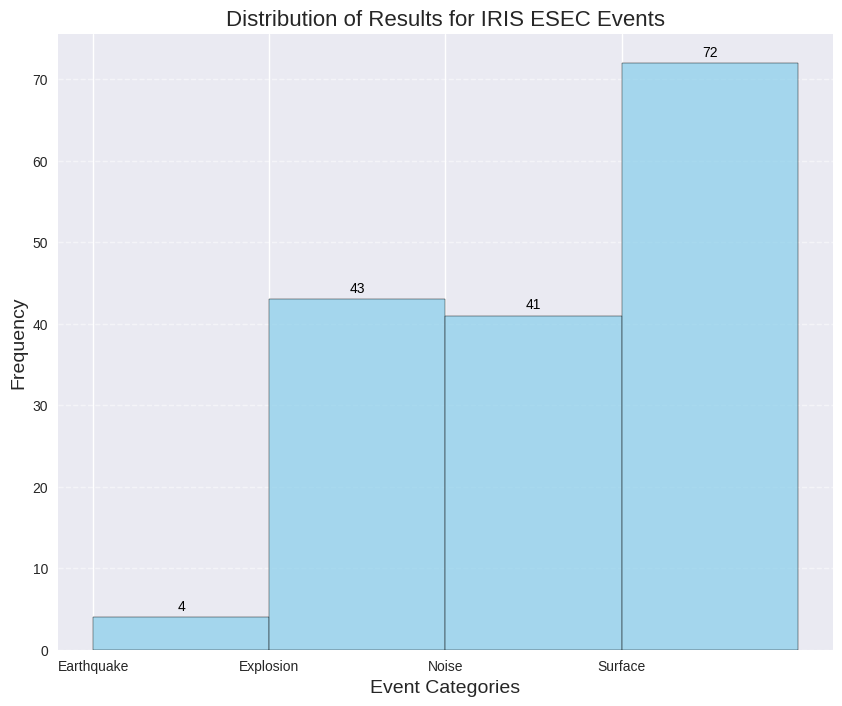

In [309]:
plt.style.use('seaborn')
plt.figure(figsize=(10, 8))
ax = sns.histplot(results, bins=range(5), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Results for IRIS ESEC Events', fontsize=16)
plt.xlabel('Event Categories', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(range(4), labels=['Earthquake', 'Explosion', 'Noise', 'Surface'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding annotations with the number of events in each bin
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

## Event wise distribution of the results

In [310]:
features_new['eq_probs']  = probs[:,0]
features_new['px_probs']  = probs[:,1]
features_new['no_probs']  = probs[:,2]
features_new['su_probs']  = probs[:,3]

grouped_features = features_new.groupby('event_id').mean().loc[:,['eq_probs', 'px_probs', 'no_probs', 'su_probs']]
max_probs = grouped_features.max(axis=1)
argmax_probs = grouped_features.apply(lambda row: np.argmax(row.values), axis=1)


grouped_features['max_probs'] = max_probs
grouped_features['labels'] = argmax_probs

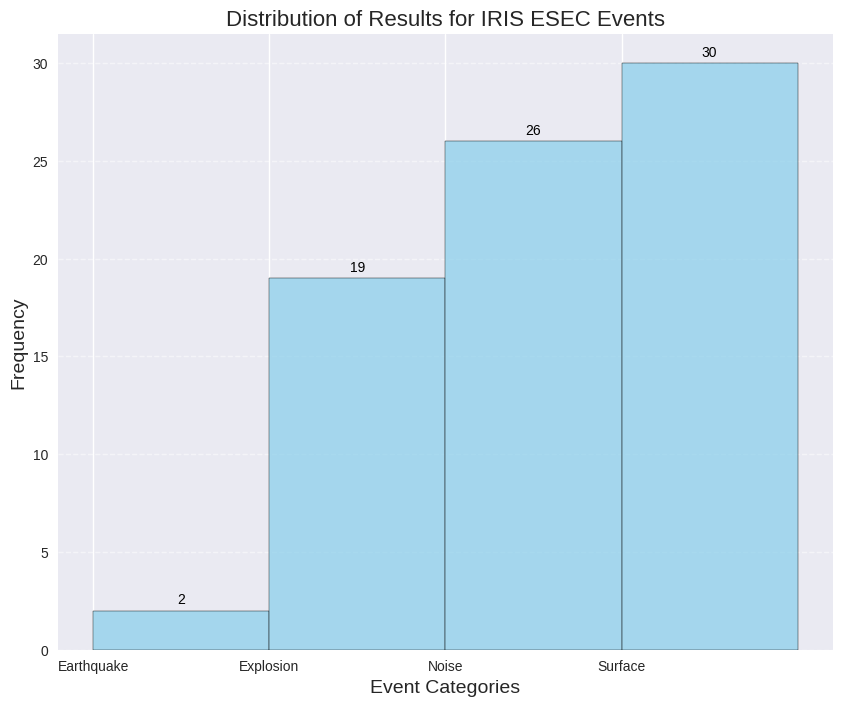

In [311]:
plt.style.use('seaborn')
plt.figure(figsize=(10, 8))
ax = sns.histplot(argmax_probs, bins=range(5), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Results for IRIS ESEC Events', fontsize=16)
plt.xlabel('Event Categories', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(range(4), labels=['Earthquake', 'Explosion', 'Noise', 'Surface'])
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adding annotations with the number of events in each bin
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

## Plotting the distribution of event types in each class

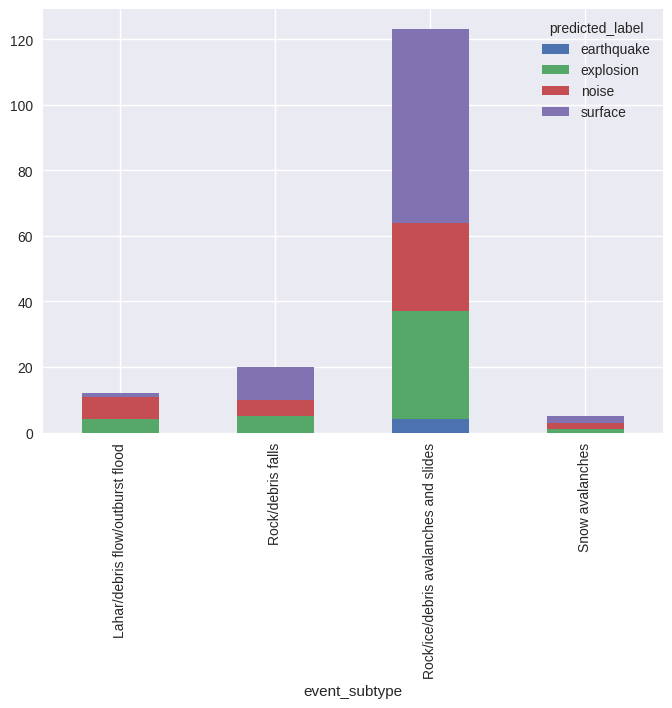

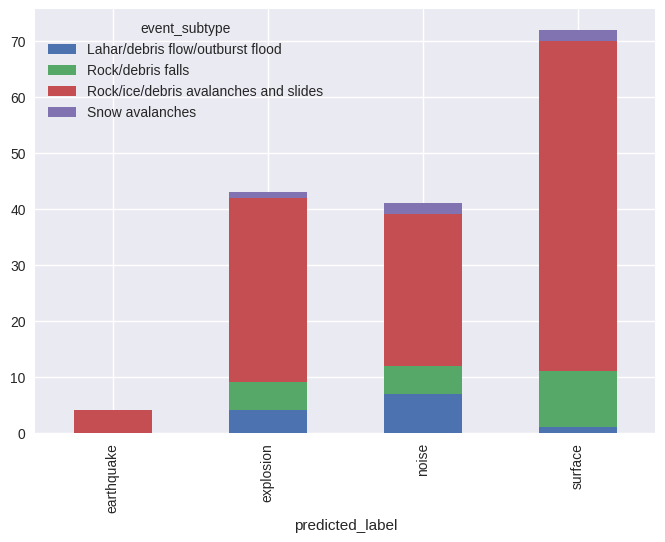

In [312]:
classes = ['earthquake', 'explosion', 'noise', 'surface']
features_ex_physical['predicted_label'] = [classes[results[i]] for i in range(len(results))]

# Assuming 'predicted_class' is the column with predicted classes
grouped = features_ex_physical.groupby(['event_subtype', 'predicted_label']).size().unstack()

# Plot stacked histogram
grouped.plot(kind='bar', stacked=True)

# Show the plot
plt.show()



# Assuming 'predicted_class' is the column with predicted classes
grouped = features_ex_physical.groupby(['predicted_label', 'event_subtype']).size().unstack()

# Plot stacked histogram
grouped.plot(kind='bar', stacked=True)

# Show the plot
plt.show()

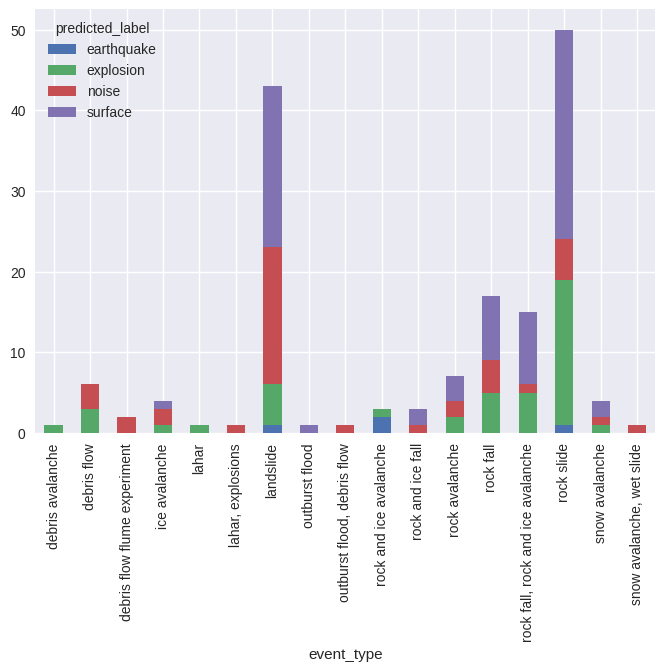

In [313]:
# Assuming 'predicted_class' is the column with predicted classes
grouped = features_ex_physical.groupby(['event_type', 'predicted_label']).size().unstack()

# Plot stacked histogram
grouped.plot(kind='bar', stacked=True)

# Show the plot
plt.show()